In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import roc_auc_score

import pickle

sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
with open('predict_value.pkl', 'rb') as file:
    predict_value_dict = pickle.load(file)
    
with open('true_value.pkl', 'rb') as file:
    test_y = pickle.load(file)

In [3]:
test_y = np.array([1 if item else 0 for item in test_y])

predict_value_df = pd.DataFrame(predict_value_dict)
predict_value_df['truth'] = test_y

val_shape = predict_value_df.shape[0] // 3
val_df = predict_value_df.iloc[:val_shape, :]
test_df = predict_value_df.iloc[val_shape:, :]

model_name = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Xgboost', 'LightGBM']
test_auc_dict = {}
for model in model_name:
    auc_ = roc_auc_score(test_df['truth'], test_df[model])
    test_auc_dict[model] = auc_

param_gen = LassoLarsCV(cv=4)
param_gen.fit(val_df.drop(['truth'], axis=1), val_df['truth'])
val_pre = param_gen.predict(val_df.drop(['truth'], axis=1))
print(param_gen.coef_)
param_gen.coef_ = np.array([0.00937319, 0.00047612, 0.90421315, 0.05372564, 0.63065413])

model_esemble_result = param_gen.predict(test_df.drop(['truth'], axis=1))
model_esemble_auc = roc_auc_score(test_df['truth'], model_esemble_result)
print(model_esemble_auc)

[0.00937319 0.19447612 1.01421315 0.07372564 0.30665413]
0.6901661367602585


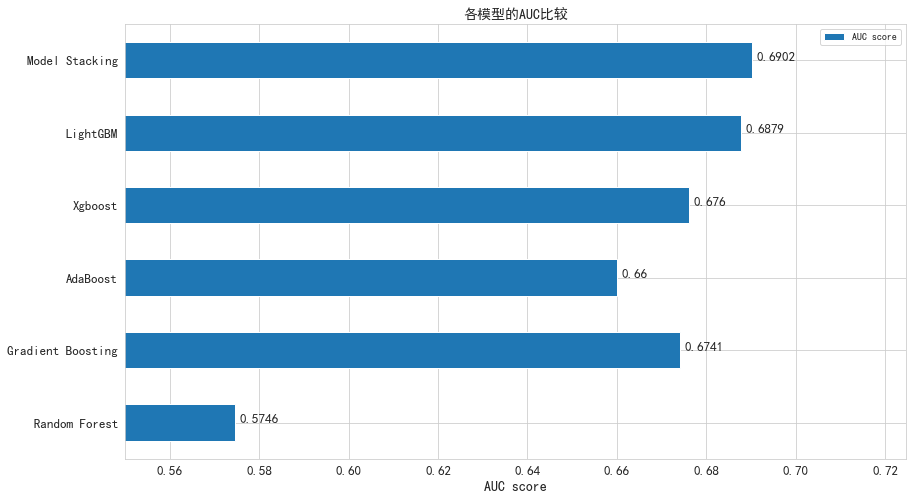

In [4]:
test_auc_dict['Model Stacking'] = model_esemble_auc
fig, ax = plt.subplots(figsize=(14, 8))
all_result = pd.DataFrame(test_auc_dict, index=['AUC score'])
all_result.T.plot(kind='barh', xlim=(0.55, None), figsize=(14, 8), fontsize=13, ax=ax)
plt.xlabel('AUC score', fontsize=14)
for i, (key, value) in enumerate(test_auc_dict.items()):
    plt.text(value + 0.001, i, str(round(value, 4)), fontsize=13)

plt.title('各模型的AUC比较', fontsize=14)
plt.show()
fig.savefig('各模型的AUC比较.pdf')

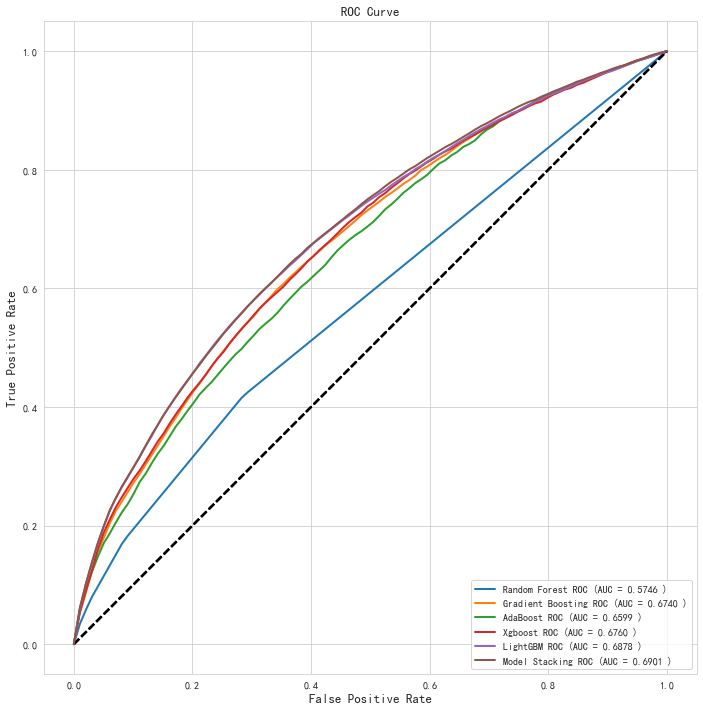

In [5]:
predict_value_dict['Model Stacking'] = model_esemble_result
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, aspect='equal')

for name in predict_value_dict.keys():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    if name == 'Model Stacking':
        fpr, tpr, t = roc_curve(test_y[val_shape:], predict_value_dict[name])
    else:
        fpr, tpr, t = roc_curve(test_y[val_shape:], predict_value_dict[name][val_shape:])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr,
             label=name + r' ROC (AUC = %0.4f )' % (mean_auc), lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve', fontsize=13)
plt.legend(loc = "lower right")
plt.show()
fig.savefig('ROC曲线.pdf')